In [1]:
from __future__ import print_function

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,ReduceLROnPlateau

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
# from tensorflow.keras.datasets import mnist, cifar10
import tensorflow_addons as tfa

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.io import loadmat 
import mat73
from datetime import datetime
import ipynbname

print("Packages Loaded")

Packages Loaded


In [2]:
import wandb
from wandb.keras import WandbCallback
time_stamp = datetime.strftime( datetime.now(),'%d_%B_%y_%H_%M')
Uniqueness_of_model = 'Experimenting with findpeaks(straight) data: Want to attempt shuffling of the data with ConvResNet with 3Blocks'

wandb.init(project="my-test-project", entity="ibksolar", name="Conv3BlocksJan2022_withfindpeaks_"+time_stamp)
 


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ibksolar (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
# base_path = '..\\..\\all_block_data\Dec_Train_block_len_21_011121_2331'
#base_path = '../all_block_data/Old_data/Dec_Train_block_len_21_231121_1531'
base_path = '../all_block_data\FindPeaks_data\Dec_Train_block_len_21_030122_0614'

# Confirm path is right...
print(f'{os.path.isdir(base_path)}')

True


In [4]:

raw_data1 = mat73.loadmat(base_path + '/echo_cnn_in_out_jstars.mat')
all_data = raw_data1['echo_cnn_input']
all_target = raw_data1['echo_cnn_target']
coords = raw_data1['coords']
echo_idx = raw_data1['orig_echo_idx']

# Set all nan in the data to zero
nan_idx = np.isnan(all_data).any(axis =-1)
all_target[nan_idx] = 0
all_data[ np.isnan(all_data) ]= 0



In [7]:
# Truncate data because data after truncate point is notgood for training
truncate_data = False
if truncate_data:    
    echo_idx = np.asarray(echo_idx)
    stop_val = 600

    stop_list, = np.where(echo_idx == stop_val)
    stop_idx = stop_list[-1]

    all_data = all_data[:stop_idx]
    all_target = all_target[:stop_idx]

    print(f'Data shape {all_data.shape}')
    print(f'Target shape {all_target.shape}')


In [8]:
row_length = 21 # CHANGE HERE <==
col_length = 15

# Check that the dimension of data is correct
if all_data.shape[1] == row_length*col_length:
    print('Dimensions match')
else:
    print(f' Row block length:{row_length} and col length:{col_length} does not match Data dimension:{all_data.shape[1]}') 
        

Dimensions match


In [9]:
max_class = row_length 

# Highest class is mapped to row_length+1
all_target[all_target == max_class+1 ] = 0


shuffle = 1
if shuffle:
    random.Random(1337).shuffle(all_data)
    random.Random(1337).shuffle(all_target)
    # random.Random(1337).shuffle(all_idx)

## Prep data
train_size = int(np.floor(0.8*len(all_target)));
test_size = int(np.round( 0.15* all_data.shape[0] ))
val_size = all_data.shape[0] -train_size - test_size

mid_pt = 8
x_train = all_data[0:train_size,:]
x_train = np.reshape( x_train, (x_train.shape[0],max_class,-1,1), order = 'F' )
x_train = x_train[:,:,mid_pt-2:mid_pt+3,:]

x_test = all_data[train_size:train_size+test_size,:]
x_test = np.reshape( x_test,(x_test.shape[0],max_class,-1,1), order = 'F' )
x_test = x_test[:,:,mid_pt-2:mid_pt+3,:]

x_val = all_data[-val_size:,:]
x_val = np.reshape( x_val,(x_val.shape[0],max_class,-1,1), order = 'F' )
x_val = x_val[:,:,mid_pt-2:mid_pt+3,:]

y_train = all_target[:train_size]
y_test  = all_target[train_size:train_size+test_size]
y_val = all_target[-val_size:]

var_input_shape = x_train.shape[1:] # 240 columns
num_classes = max_class+1 # layers


# Convert labels to categorical orthonormal vectors
# y_train = tf.keras.utils.to_categorical(y_train, num_classes)
# y_test  = tf.keras.utils.to_categorical(y_test, num_classes)

print(f'Shape of X_train:{x_train.shape}  X_test:{x_test.shape}')
print(f'Shape of y_train:{y_train.shape}  y_test:{y_test.shape}')

Shape of X_train:(1897984, 21, 5, 1)  X_test:(355872, 21, 5, 1)
Shape of y_train:(1897984,)  y_test:(355872,)


In [8]:
print(num_classes)
print(len(np.unique(y_train)))

22
22


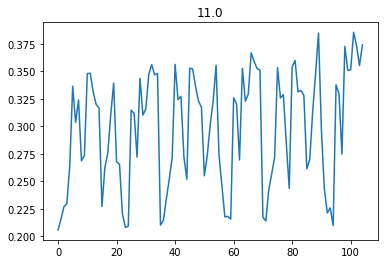

In [26]:
# Visualize some of the input

_ = plt.plot(x_train[200].flatten())
_ = plt.title(y_train[200])

In [10]:
# Populate the param log
log ={}
log['Notebook_name'] = "Conv3Blocks" #ipynbname.name()
log['Uniqueness_of_each_run'] = Uniqueness_of_model
log['base_dir'] = base_path
log['Train_shape'] = x_train.shape
log['Output_shape'] = ''
log['num_epochs'] = ''
log['batch_size'] = ''
log['activation_function'] = ''
log['optimizer'] = ''
log['learning_rate'] = ''
log['loss_finction'] = ''
log['accuracy'] = []
log['loss'] = []
log['stop_time'] = ''
log['Model_config'] = ''
log['Performance_on_test_set'] = ''
log['output_path'] = ''  # output: where the trained model is saved
log['shuffle'] = shuffle
log['run_completion_comment'] = '' # Comment on training and probably evaluation too

from model_hyper_param_log import create_log_entry, update_log_entry
if "log_idx" in globals():
    log["S_N"] = log_idx
log_idx = create_log_entry('../testing_sheet2.xlsx', log)

Could not get file name: auto-generating name
Activation_function not in workspace
extras  is not in workspace
Current run hyper_params are dict_keys(['S_N', 'Start_time', 'NoteBook_name', 'Uniqueness_of_each_run', 'Base_dir', 'Train_shape', 'Output_shape', 'num_epochs', 'Activation_function', 'optimizer', 'learning_rate', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop_time', 'Model_config', 'Performance_on_test_set', 'output_path', 'shuffle', 'Computer_name', 'extras']):dict_values([3, '05_January_22_0733', 'Conv3Blocks', 'Experimenting with findpeaks(straight) data: Want to attempt shuffling of the data with ConvResNet with 3Blocks', '../all_block_data\\FindPeaks_data\\Dec_Train_block_len_21_030122_0614', (1897984, 21, 5, 1), '', '', '', '', '', '', [], [], '', '', '', '', 1, 'AQ-LHJBMA1', ''])
Fields to be updated include: ['Activation_function', 'learning_rate', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop_time', 'Model_config', 'Performance_on_tes

In [31]:
# DO NOT RUN!!! This has template result to be matched

# Define Sequential model with 3 layers
num_epochs = 70
batch_size = 64
nodes = 256
learning_rate = 0.003 #0.0001

wandb.config = { "learning_rate": "learning_rate",   "epochs": num_epochs,
  "batch_size": batch_size,  "nodes": nodes,  "row_length":row_length,  "base_path":base_path }

input_shape = (21,5,1)

def ResNetBlock(x,dropout):
    conv1 = x
    for _ in range(5):                
        conv1 = layers.BatchNormalization()(conv1)
        conv1 = layers.ReLU()(conv1)
        conv1 = layers.SeparableConv2D(filters=64, kernel_size=3, padding="same")(conv1) #input_layer
        conv1 = layers.SeparableConv2D(filters=64, kernel_size=3, padding="same")(conv1) # input_layer, Conv1D    
        conv1 = layers.BatchNormalization()(conv1)
        conv1 = layers.ReLU()(conv1)
        conv1 = layers.Dropout(dropout)(conv1)
    
    res = layers.add([x,conv1])
    x = layers.ReLU()(res) # Overwrite x    
    return x

def ResNetBlock2(x):
    x =   layers.Conv2D(filters=64, kernel_size=3, padding="same")(x) #input_layer
    conv1 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x) # input_layer, Conv1D
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    
    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    
    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.add([x,conv3])
    x = layers.ReLU()(conv3) # Overwrite x
    
    return x

def make_model(input_shape,dropout):
    input_layer = layers.Input(input_shape)    
    x =   layers.Conv2D(filters=64, kernel_size=3, padding="same")(input_layer)    
    
    for _ in range(30):
        x = ResNetBlock2(input_layer,dropout)
    
    # conv1 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(input_layer) #Conv1D
    # conv1 = layers.BatchNormalization()(conv1)
    # conv1 = layers.ReLU()(conv1)
    # conv2 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv1)
    # conv2 = layers.BatchNormalization()(conv2)
    # conv2 = layers.ReLU()(conv2)
    # conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    # conv3 = layers.BatchNormalization()(conv3)
    # conv3 = layers.ReLU()(conv3)
    
    gap = layers.GlobalAveragePooling2D()(x)    
    gap = layers.Flatten()(gap)
    gap = layers.Dropout(0)(gap)
    gap = layers.Dense(128, activation="softmax")(gap)
    output_layer = layers.Dense(num_classes, activation="softmax")(gap)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape = input_shape,dropout = 0) #x_train.shape[1:]


callbacks = [
    ModelCheckpoint(base_path+'/'+ipynbname.name()+"/best_model.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=5, min_lr=0.0001),
    #EarlyStopping(monitor="val_loss", patience=25, verbose=1), 
    WandbCallback()
]



# Poly Rate scheduler ( This kept having issues)
starter_learning_rate = 0.01
end_learning_rate = 0.0001
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.25)


opt1 = tf.keras.optimizers.RMSprop(learning_rate=learning_rate,rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop")
opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate,amsgrad=True)
poly_rate = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn) # All the schedulers gives errors
poly_rate2 = tf.keras.optimizers.Adam(learning_rate = learning_rate_fn)
# top_K = 3
# model.compile( optimizer = opt, loss= 'categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")])  #label_smoothing=0.05, tf.keras.losses.KLDivergence()

model.compile( optimizer=opt2,loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy",tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)] )


history = model.fit(x_train, y_train,
          epochs= num_epochs, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test),
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]



Epoch 1/70
11835/11835 [==============================] - 753s 63ms/step - loss: 2.4890 - sparse_categorical_accuracy: 0.1335 - sparse_top_k_categorical_accuracy: 0.3829 - val_loss: 2.3137 - val_sparse_categorical_accuracy: 0.1731 - val_sparse_top_k_categorical_accuracy: 0.4632 - lr: 3.0000e-04
Epoch 2/70
11835/11835 [==============================] - 766s 65ms/step - loss: 2.3895 - sparse_categorical_accuracy: 0.1686 - sparse_top_k_categorical_accuracy: 0.4370 - val_loss: 2.2221 - val_sparse_categorical_accuracy: 0.2431 - val_sparse_top_k_categorical_accuracy: 0.5704 - lr: 3.0000e-04
Epoch 3/70
11835/11835 [==============================] - 749s 63ms/step - loss: 2.3322 - sparse_categorical_accuracy: 0.2178 - sparse_top_k_categorical_accuracy: 0.5132 - val_loss: 2.0592 - val_sparse_categorical_accuracy: 0.3354 - val_sparse_top_k_categorical_accuracy: 0.7480 - lr: 3.0000e-04
Epoch 4/70
11835/11835 [==============================] - 765s 65ms/step - loss: 2.3133 - sparse_categorical_acc

In [32]:
_, accuracy,top_3_accuracy = model.evaluate(x_val, y_val)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_3_accuracy * 100, 2)}%")


model.save(f'{base_path}//NewResNet_weights_3ConvBlocks//{time_stamp}_Acc_{accuracy:.3f}_{row_length}x{col_length}.h5')

1480/1480 [==============================] - 30s 20ms/step - loss: 1.4855 - sparse_categorical_accuracy: 0.5992 - sparse_top_k_categorical_accuracy: 0.8544
Test accuracy: 59.92%
Test top 5 accuracy: 85.44%


In [13]:
# Same code as the training cell above is repeated to use the previous output as reference
num_epochs = 70
batch_size = 128 #128, 256
nodes = 256
learning_rate = 3e-2 #0.0001
dropout = 0.2

wandb.config = { "learning_rate": "learning_rate",   "epochs": num_epochs,
  "batch_size": batch_size,  "nodes": nodes,  "row_length":row_length,  "base_path":base_path }
wandb.config.update(log)

# Update log['extras']
log['extras'] = wandb.config
#### ===== End of logging ========

input_shape = (21,5,1)

def ResNetBlock(x,dropout):
    conv1 = x
    for _ in range(5):                
        conv1 = layers.BatchNormalization()(conv1)
        conv1 = layers.ReLU()(conv1)
        conv1 = layers.SeparableConv2D(filters=64, kernel_size=3, padding="same")(conv1) #input_layer
        conv1 = layers.SeparableConv2D(filters=64, kernel_size=3, padding="same")(conv1) # input_layer, Conv1D    
        conv1 = layers.BatchNormalization()(conv1)
        conv1 = layers.ReLU()(conv1)
        conv1 = layers.Dropout(dropout)(conv1)
    
    res = layers.add([x,conv1])
    x = layers.ReLU()(res) # Overwrite x    
    return x

def ResNetBlock2(x):
    num_filters = 128
    k_size = 3 #(21,3)
    
    x =   layers.Conv2D(filters=num_filters, kernel_size=k_size, padding="same")(x) #input_layer
    conv1 = layers.Conv2D(filters=num_filters, kernel_size=k_size, padding="same")(x) # input_layer, Conv1D
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv2D(filters=num_filters, kernel_size=k_size, padding="same")(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters=num_filters, kernel_size=k_size, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    
    conv3 = layers.Conv2D(filters=num_filters, kernel_size=k_size, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    
    conv3 = layers.Conv2D(filters=num_filters, kernel_size=k_size, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.add([x,conv3])
    x = layers.ReLU()(conv3) # Overwrite x
    
    return x

def make_model(input_shape,dropout):
    input_layer = layers.Input(input_shape)    
    x =  layers.Conv2D(filters=64, kernel_size=3, padding="same")(input_layer)    
    
    for _ in range(30):
        x = ResNetBlock2(x) #input_layer,dropout
    
    # conv1 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(input_layer) #Conv1D
    # conv1 = layers.BatchNormalization()(conv1)
    # conv1 = layers.ReLU()(conv1)
    # conv2 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv1)
    # conv2 = layers.BatchNormalization()(conv2)
    # conv2 = layers.ReLU()(conv2)
    # conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    # conv3 = layers.BatchNormalization()(conv3)
    # conv3 = layers.ReLU()(conv3)
    
    gap = layers.GlobalAveragePooling2D()(x)    
    gap = layers.Flatten()(gap)
    gap = layers.Dense(256, activation="softmax")(gap)
    gap = layers.Dropout(dropout)(gap)    
    output_layer = layers.Dense(num_classes, activation="softmax")(gap)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape = input_shape,dropout = dropout) #x_train.shape[1:]

try:
    Nb_name = ipynbname.name()
except:
    Nb_name ="Conv3Blocks"

callbacks = [
    ModelCheckpoint(base_path+'/'+Nb_name+"/best_model.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=0.0001,verbose = 1),
    #EarlyStopping(monitor="val_loss", patience=25, verbose=1), 
    WandbCallback()
]



# Poly Rate scheduler ( This kept having issues)
starter_learning_rate = 0.01
end_learning_rate = 0.0001
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.25)


opt1 = tf.keras.optimizers.RMSprop(learning_rate=learning_rate,rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop")
opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate,amsgrad=True)

weight_decay = 0.005 #0.3
opt3 = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay) #Adam(amsgrad=True)

poly_rate = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn) # All the schedulers gives errors
poly_rate2 = tf.keras.optimizers.Adam(learning_rate = learning_rate_fn)
# top_K = 3
# model.compile( optimizer = opt, loss= 'categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")])  #label_smoothing=0.05, tf.keras.losses.KLDivergence()

start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
print(f'Training start time:{start_time}')

model.compile( optimizer=opt3,loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy",tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)] )


history = model.fit(x_train, y_train,
          epochs= num_epochs, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test),
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]

# Update manual log file
params_to_be_updated = update_log_entry('../testing_sheet2.xlsx', log['S_N'], model, history)

Training start time:05_January_22_1140
Epoch 1/70
 9783/14828 [==================>...........] - ETA: 36:45 - loss: nan - sparse_categorical_accuracy: 0.0831 - sparse_top_k_categorical_accuracy: 1.0861e-04

KeyboardInterrupt: 

In [10]:
# Train ResNet2 model further (100 epochs more??)

extra_epochs = 100

history2 = model.fit(x_train, y_train,
          epochs= extra_epochs, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test),
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]



Epoch 1/100
11835/11835 [==============================] - 79s 7ms/step - loss: 2.2138 - sparse_categorical_accuracy: 0.2859 - sparse_top_k_categorical_accuracy: 0.5417 - val_loss: 1.7609 - val_sparse_categorical_accuracy: 0.5028 - val_sparse_top_k_categorical_accuracy: 0.8081 - lr: 0.0030
Epoch 2/100
11835/11835 [==============================] - 78s 7ms/step - loss: 2.2082 - sparse_categorical_accuracy: 0.2891 - sparse_top_k_categorical_accuracy: 0.5436 - val_loss: 1.7331 - val_sparse_categorical_accuracy: 0.4917 - val_sparse_top_k_categorical_accuracy: 0.8001 - lr: 0.0030
Epoch 3/100
11835/11835 [==============================] - 79s 7ms/step - loss: 2.2039 - sparse_categorical_accuracy: 0.2911 - sparse_top_k_categorical_accuracy: 0.5453 - val_loss: 1.6962 - val_sparse_categorical_accuracy: 0.5184 - val_sparse_top_k_categorical_accuracy: 0.8152 - lr: 0.0030
Epoch 4/100
11835/11835 [==============================] - 79s 7ms/step - loss: 2.2006 - sparse_categorical_accuracy: 0.2926 - 

In [15]:

_, accuracy,top_5_accuracy = model.evaluate(x_val, y_val)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

#_,new_col_length,new_row_length = x_train.shape 
model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top5Acc_{top_5_accuracy:.3f}_315x1.h5')

1480/1480 [==============================] - 6s 4ms/step - loss: 1.4411 - sparse_categorical_accuracy: 0.6096 - sparse_top_k_categorical_accuracy: 0.8829
Test accuracy: 60.96%
Test top 5 accuracy: 88.29%


In [16]:

import random
check_start = random.randint(0,len(x_val))

print(f'Check start idx: {check_start}')
[(int(y_val[idx]), np.argmax(model.predict(np.expand_dims(x_val[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]

Check start idx: 30035


[(9, 9),
 (14, 14),
 (14, 14),
 (10, 9),
 (12, 11),
 (11, 11),
 (7, 8),
 (10, 10),
 (13, 13),
 (12, 11),
 (8, 9),
 (14, 15),
 (13, 13),
 (12, 12),
 (14, 14),
 (10, 10),
 (8, 9),
 (13, 13),
 (10, 10),
 (8, 8)]

In [ ]:
# Load model from previous training
load_model = 0
if load_model:
    model = tf.keras.models.load_model(r'Y:\ibikunle\Python_Project\Fall_2021\all_block_data\Old_data\Dec_Train_block_len_21_131121_2213\NewResNet_weights_3ConvBlocks\NewResNet_Nov21\NewConv1_model_19_November_21_12_04_Acc_0.6530701518058777_21x15.h5')

In [39]:
# Train further
# Define Sequential model with 3 layers
num_epochs = 30
batch_size = 64
nodes = 256
learning_rate = 1e-3

wandb.config = {
  "learning_rate": "learning_rate",
  "epochs": num_epochs,
  "batch_size": batch_size,
  "nodes": nodes,
  "row_length":row_length,
  "base_path":base_path

}

callbacks = [
    ModelCheckpoint(base_path+"//NewResNet_weights_3ConvBlocks//"+time_stamp+"_best_model.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=10, min_lr=0.0001),    
    WandbCallback()
]

history = model.fit(x_train, y_train,
          epochs= num_epochs, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test),
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]

Epoch 1/30
11835/11835 [==============================] - 785s 66ms/step - loss: 2.1430 - sparse_categorical_accuracy: 0.3381 - sparse_top_k_categorical_accuracy: 0.5715 - val_loss: 1.6048 - val_sparse_categorical_accuracy: 0.5650 - val_sparse_top_k_categorical_accuracy: 0.8099 - lr: 1.0000e-04
Epoch 2/30
11835/11835 [==============================] - 815s 69ms/step - loss: 2.1422 - sparse_categorical_accuracy: 0.3387 - sparse_top_k_categorical_accuracy: 0.5719 - val_loss: 1.5992 - val_sparse_categorical_accuracy: 0.5687 - val_sparse_top_k_categorical_accuracy: 0.8126 - lr: 1.0000e-04
Epoch 3/30
11835/11835 [==============================] - 804s 68ms/step - loss: 2.1415 - sparse_categorical_accuracy: 0.3389 - sparse_top_k_categorical_accuracy: 0.5722 - val_loss: 1.5966 - val_sparse_categorical_accuracy: 0.5678 - val_sparse_top_k_categorical_accuracy: 0.8110 - lr: 1.0000e-04
Epoch 4/30
11835/11835 [==============================] - 808s 68ms/step - loss: 2.1414 - sparse_categorical_acc

In [45]:
_, accuracy,top_3_accuracy = model.evaluate(x_val, y_val)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_3_accuracy * 100, 2)}%")

_,new_col_length,new_row_length,_ = x_train.shape 
model.save(f'{base_path}//NewResNet_weights_3ConvBlocks//{time_stamp}_Acc_{accuracy:.3f}_Top3Acc{top_3_accuracy:.3f}_{new_row_length}x{new_col_length}.h5')

1480/1480 [==============================] - 31s 21ms/step - loss: 1.4794 - sparse_categorical_accuracy: 0.6039 - sparse_top_k_categorical_accuracy: 0.8525
Test accuracy: 60.39%
Test top 5 accuracy: 85.25%
